# BioSound Tutorial 4.  Supervised Classification with BioSound properties.
### This notebook illustrates how to perform LDA, QDA and RF on data that has been pre-processed by BioSound.

LDA : Linear Discriminant Analysis  
QDA : Quadratic Discriminant Analysis  
RF  : Random Forest  

At this stage, you have transformed all your sound files into BioSound objects and generated a pandas table where you have saved the parameters of interest as in tutorial 3.

## Step 1. Loading all the dependencies.  
### numpy, soundsig and pandas. 

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.discriminate import discriminatePlot

# Make plots on this Notebook.
%matplotlib inline


## Step 2. Specifying the pandas table and reading it.

You will want to change the location for storing the pandas table to the one you specified in tutorial 3.

In [2]:
# The pandas data frame location (from tutorial 3):
tableStore = '/Users/frederictheunissen/Code/BioSoundTutorial/vocSelTable.h5'

# This is where you want to store eps of figures that will be generated.
figdir = '/Users/frederictheunissen/Code/BioSoundTutorial/'

# Let's read it:
vocSelTable = pd.read_hdf(tableStore)

## Step 3. Supervised Classification with cross-validation.  

Here we are going to see how well bird id can be classified using lda, qda and rf.  The routine discriminatePlot fits these supervised classifiers after pre-processing.  The pre-processing involves removing groups that have insufficent data and performing a PCA on the features used by the classifier as a form of regularization (to prevent overfitting).  The PCA is performed when there is insufficent data in each group to get good estimates of the within group covariance matrix.  The performance of the classifiers using 10 fold cross-validation.  Alternatively, one can specify indexes that will be used uniquely in the testing set of the classifiers (testInd - see discriminatePlot() in soundsig/discriminate.  


Variance explained is 100.00%
DFA calculated with 91 points
LDA Weights:
DFA 0: fund -0.031; F2 0.002; F3 -0.001; F1 -0.000; sal -0.000; 
DFA 1: F3 0.006; F2 -0.004; F1 -0.001; fund -0.000; sal 0.000; 
DFA 2: fund -0.006; F3 0.005; F2 -0.003; F1 0.003; sal -0.000; 
Number of classes 4. Chance level 25.00 %
Formants + Fund LDA: 82.42 % (75/91 p=0.0000)
Formants + Fund QDA: 81.32 % (74/91 p=0.0000)
Formants + Fund RF: 76.92 % (70/91 p=0.0000)


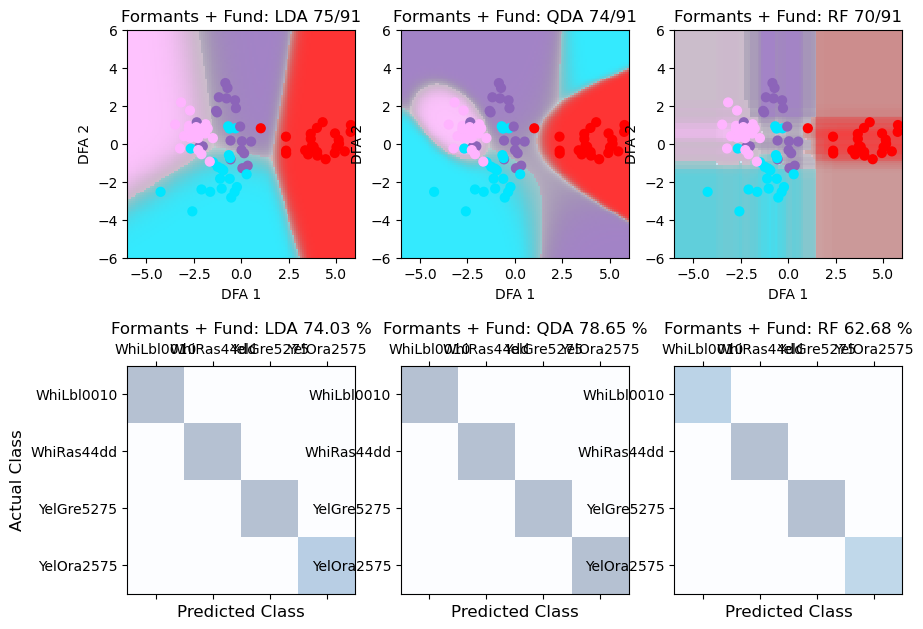

In [6]:
#  Here we generate colors for each bird for plotting purposes:

# Color code for bird ID
birdColorStart = [(0/255.0, 230/255.0, 255/255.0),  
             (255/255.0, 0/255.0, 0/255.0), 
             (255/255.0, 180/255.0, 255/255.0),
             (140/255.0, 100/255.0, 185/255.0) ]



birdNames = np.unique(vocSelTable['Bird'])

# If you have a small number of birds you might want to choose specific colors
birdColor = {}
ib = 0
for birdId in birdNames:
    if ib < 4:
       birdColor[birdId] = birdColorStart[ib] 
    else:
       birdColor[birdId] = np.random.rand(3)
    ib += 1
    
cValBirdAll = []
for birdId in vocSelTable['Bird']:
    cValBirdAll.append(birdColor[birdId])
    
cValBirdAll = np.asarray(cValBirdAll)


# Can we classify bird id using the average formants, pitch saliency, fundamental and the cv fund ?

# X is the data array of features.
# y is the variable name for the grouping variable 
XFeatureNames = np.hstack(('F1', 'F2', 'F3', 'sal', 'fund','cvfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Bird'])


# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants + Saliency + Fund Model 
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBirdAll[nonanInd], 
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Formants + Fund',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)

# The confusion matrices are returned without normalization so that exact statistics can also be calculated.
# Here they are notmalized to get values in terms of posterior prabability

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)

d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Formants + Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post SE': np.array([100.0*post_se_lda]),
     'QDA Post SE': np.array([100.0*post_se_qda]),
     'RF Post SE': np.array([100.0*post_se_rf])
    }
     
resultsDataFrame = pd.DataFrame(data = d)

### Let's perform a second discrimination without using the formants.

Are formants helpful (beyond fundamental) to discriminate bird id?

Variance explained is 100.00%
DFA calculated with 91 points
LDA Weights:
DFA 0: sal -15.966; cvfund 1.554; fund -0.023; 
DFA 1: sal 14.740; cvfund -4.656; fund -0.019; 
DFA 2: cvfund -15.942; sal -11.682; fund 0.001; 
Number of classes 4. Chance level 25.00 %
Fund LDA: 79.12 % (72/91 p=0.0000)
Fund QDA: 82.42 % (75/91 p=0.0000)
Fund RF: 82.42 % (75/91 p=0.0000)


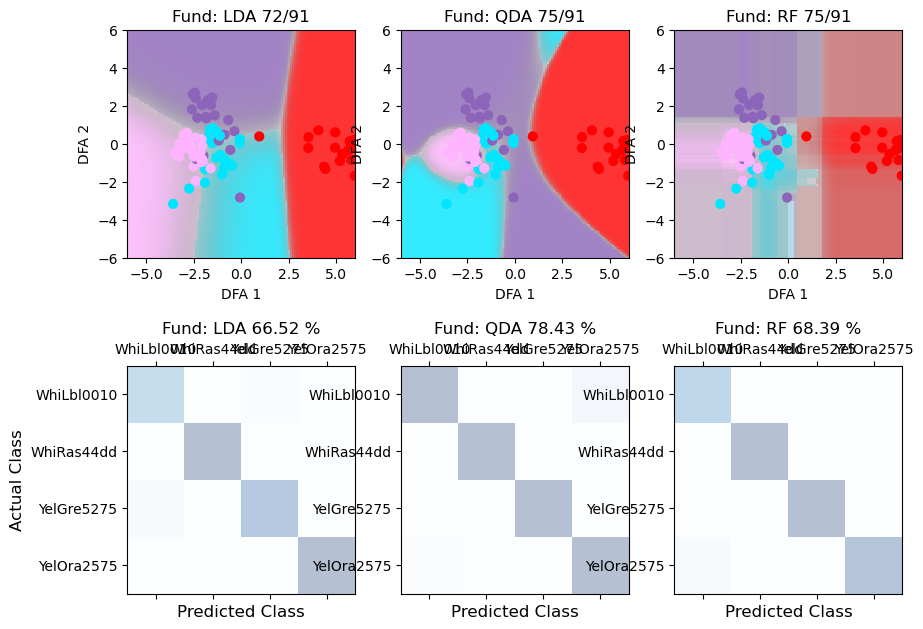

In [7]:
# X is the data array of features.
# y is the variable name for the grouping variable 

XFeatureNames = np.hstack(('sal', 'fund','cvfund'))
X = [vocSelTable.loc[:,col] for col in XFeatureNames ]
X = np.stack(X, axis=1)

y = np.array(vocSelTable['Bird'])

# Exclude entries that have nan
nonanInd = (np.sum(np.isnan(X), axis = 1) == 0)

# Formants + Fund Model
ldaYes, qdaYes, rfYes, cvCount, ldaP, qdaP, rfP, ldaConf, qdaConf, rfConf, cvCountConf, classes, nClasses, weights = discriminatePlot(X[nonanInd], y[nonanInd], 
                                                                                            cValBirdAll[nonanInd],
                                                                                            Xcolname = XFeatureNames,
                                                                                            titleStr = 'Fund',
                                                                                            figdir = figdir,
                                                                                            plotFig = True)

#Normalize the confusion matrices and calculate posteriors and SE
lda_conf = np.copy(ldaConf)
for i in range(lda_conf.shape[0]):
    lda_conf[i,:] = lda_conf[i,:]/cvCountConf[i]
    
qda_conf = np.copy(qdaConf)
for i in range(qda_conf.shape[0]):
    qda_conf[i,:] = qda_conf[i,:]/cvCountConf[i]
    
rf_conf = np.copy(rfConf)
for i in range(rf_conf.shape[0]):
    rf_conf[i,:] = rf_conf[i,:]/cvCountConf[i]

post_lda = np.diag(lda_conf).mean()
n = np.sum(cvCountConf)
post_se_lda = np.sqrt(post_lda*(1.0 - post_lda)/n)
post_qda = np.diag(qda_conf).mean()
n = np.sum(cvCountConf)
post_se_qda = np.sqrt(post_qda*(1.0 - post_qda)/n)
post_rf = np.diag(rf_conf).mean()
n = np.sum(cvCountConf)
post_se_rf = np.sqrt(post_rf*(1.0 - post_rf)/n)


d = {'Type': np.array(['CallerAdult']),
     'Features': np.array(['Fund']), 
     'LDA Correct' : np.array([ldaYes]), 
     'QDA Correct': np.array([qdaYes]),
     'RF Correct': np.array([rfYes]),
     'Tested' : np.array([cvCount]),
     'nClasses' : np.array([nClasses]),
     'LDA Pval' : np.array([ldaP]),
     'QDA Pval': np.array([qdaP]),
     'RF Pval': np.array([rfP]),
     'LDA Post': np.array([100.0*post_lda]),
     'QDA Post': np.array([100.0*post_qda]),
     'RF Post': np.array([100.0*post_rf]),
     'LDA Post SE': np.array([100.0*post_se_lda]),
     'QDA Post SE': np.array([100.0*post_se_qda]),
     'RF Post SE': np.array([100.0*post_se_rf])
    }

tempdf = pd.DataFrame(data=d)
resultsDataFrame = pd.concat([resultsDataFrame, tempdf])

In [8]:
resultsDataFrame.style.format(precision = 1)

,Type,Features,LDA Correct,QDA Correct,RF Correct,Tested,nClasses,LDA Pval,QDA Pval,RF Pval,LDA Post,QDA Post,RF Post,LDA Post SE,QDA Post SE,RF Post SE
0,CallerAdult,Formants + Fund,75,74,70,91,4,0.0,0.0,0.0,74.0,78.7,62.7,4.6,4.3,5.1
0,CallerAdult,Fund,72,75,75,91,4,0.0,0.0,0.0,66.5,78.4,68.4,4.9,4.3,4.9


In this case, it can be seen that very similar discrimination is obtained using only fundamental parameters (and saliency).  The performance of the three classifiers is almost identical.

